In [813]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import networkx as nx
import scipy.linalg as la
import time

In [377]:
def weighted_sums(F, L, i, j):
    s = 0;
    for k in range(i, j):
        s = s + F[k] * L[k];
    return s

print(weighted_sums([1, 2], [3, 4], 0, 2))

11


In [733]:
from networkx.algorithms import bipartite
from networkx.algorithms.bipartite.generators import configuration_model
d = 24;
e = 16;
N = 100;
aseq = d * np.ones(int(N))
bseq = e * np.ones(int(N*d/e))
G = configuration_model(aseq.astype(int), bseq.astype(int), create_using=nx.Graph(), seed=None)

#nx.draw(G, with_labels=True)

X, Y = bipartite.sets(G)
pos = dict()
pos.update( (n, (1, i)) for i, n in enumerate(X) ) # put nodes from X at x=1
pos.update( (n, (2, i)) for i, n in enumerate(Y) ) # put nodes from Y at x=2

J = np.zeros((N, max(Y)-N+1), dtype=np.float32)
for i in range(N,max(Y)+1):
    temp = [n for n in G[i]]
    for j in range(len(G[i])):
        #J = jax.ops.index_update(J, jax.ops.index[temp[j],(i - N)], 1.)
        J[temp[j]][i-N] = 1;
#print(J)
#nx.draw(G, pos=pos, with_labels=True)
#plt.show()
#print(nx.adjacency_matrix(B, nodelist=None, weight='weight'))

In [920]:
import itertools
H = nx.MultiGraph()
H.add_nodes_from(range(N))
for i in range(max(Y)-N+1):
    Q = list(itertools.combinations(np.where(J[:,i] == 1)[0], 2))
    H.add_edges_from(Q, weight=1)
A = nx.adjacency_matrix(H)
#print(A)
#print(len(HI))
HI = nx.from_numpy_matrix(A.todense())
k = 2*nx.number_of_edges(HI)/len(HI)
B = A.todense()
W = np.unique(np.array(B))
print(k)
print(B)
average_weight = np.true_divide(B.sum(),(B!=0).sum())
print(average_weight)
#list(HI.degree())

96.3
[[0 6 7 ... 1 3 2]
 [6 0 2 ... 4 4 2]
 [7 2 0 ... 3 1 3]
 ...
 [1 4 3 ... 0 1 5]
 [3 4 1 ... 1 0 4]
 [2 2 3 ... 5 4 0]]
3.2089304257528557


In [973]:
tau = 0.0035
gamma = 1
No_of_Iterations = 10
y0 = 20
ti = 5000
print(tau * d / gamma * (e-1)/N * (N-y0))
#print(np.true_divide(W.sum(),(W!=0).sum())*tau*(k-1)/gamma)


#print(degree)
#for i in range(N):
#    degree[i] = list(HI.degree)[i][1]
#degree_squared = degree**2
#k2 = np.mean(degree_squared)
#tau * k2 / (gamma * k)

1.008


In [974]:
def cons(y, t):
    I = y[0]
    dIdt = tau * (N - I) * d * ((e-1)/N)*I - gamma * I
    #dIdt = tau * (500 - I) * 16 * ((20-1)/500)*I - gamma * I
    return  dIdt

t = np.linspace(0, ti/100, ti)
y_Simon = odeint(cons, y0, t)
print(y_Simon)
#plt.plot(y_Simon)
#plt.plot(y_pairs[:,1])
#plt.plot(I)
#plt.plot(y)

[[20.        ]
 [20.00159837]
 [20.00319284]
 ...
 [20.63491913]
 [20.63491914]
 [20.63491914]]


In [975]:
#closing at the level of pairs


def deriv(x, t):
    S, I = x
    dSdt = -tau * S * I + gamma * I
    dIdt = tau * S * I - gamma * I
    return dSdt, dIdt

S0, I0 = N-y0, y0
x0 = S0, I0
y_pairs = odeint(deriv, x0, t)
#print(y_pairs)
#plt.plot(ret[:,1])

In [976]:
S, I = np.zeros(ti), np.zeros(ti)
SI, II, SS = np.zeros((max(W)+1,ti)), np.zeros((max(W)+1,ti)), np.zeros((max(W)+1,ti))
#SI, II, SS = np.zeros((len(W),ti)), np.zeros((len(W),ti)), np.zeros((len(W),ti))
S[0] = N - y0
I[0] = y0

x = np.zeros(N)
x[:y0] = 1

W_ = np.arange(max(W)+1)

for i in range(N):
    for j in range(N):
        if i != j:
            if x[i] == 0 and x[j] == 0:
                SS[B[i,j],0] += 1;
            #if (x[i] == 0 and x[j] == 1) or (x[i] == 1 and x[j] == 0):
            if (x[i] == 0 and x[j] == 1):
                SI[B[i,j],0] += 1;
            if x[i] == 1 and x[j] == 1:
                II[B[i,j],0] += 1

for t in range(ti-1):
    S[t + 1] = S[t] + (gamma * I[t] - tau * weighted_sums(W_, SI[:,t], 0, len(W_))) * 0.01
    I[t + 1] = I[t] + (tau * weighted_sums(W_, SI[:,t], 0, len(W_)) - gamma * I[t]) * 0.01
    for m in range(len(W_)):
        print(I[t])
        
        SI[m, t + 1] = SI[m, t] + (gamma * (II[m, t] - SI[m, t]) + tau * weighted_sums(W_, ((k-1)/k*SS[m,t]/S[t])*SI[:,t]-((k-1)/k*SI[m,t]/S[t])*SI[:,t], 0, len(W_))-tau*W_[m]*SI[m,t])*0.01
        II[m, t + 1] = II[m, t] + (-2*gamma*II[m, t] + 2*tau*weighted_sums(W_, ((k-1)/k*SI[m,t]/S[t])*SI[:,t], 0, len(W_)) + 2*tau*W_[m]*SI[m,t])*0.01
        SS[m, t + 1] = SS[m, t] + (2*gamma*SI[m, t] - 2*tau*weighted_sums(W_, ((k-1)/k*SS[m,t]/S[t])*SI[:,t], 0, len(W_)))*0.01                       



20.0
20.0
20.0
20.0
20.0
20.0
20.0
20.0
20.0
20.0
20.0
19.976575
19.976575
19.976575
19.976575
19.976575
19.976575
19.976575
19.976575
19.976575
19.976575
19.976575
19.953129962288614
19.953129962288614
19.953129962288614
19.953129962288614
19.953129962288614
19.953129962288614
19.953129962288614
19.953129962288614
19.953129962288614
19.953129962288614
19.953129962288614
19.929667207930706
19.929667207930706
19.929667207930706
19.929667207930706
19.929667207930706
19.929667207930706
19.929667207930706
19.929667207930706
19.929667207930706
19.929667207930706
19.929667207930706
19.906188991777604
19.906188991777604
19.906188991777604
19.906188991777604
19.906188991777604
19.906188991777604
19.906188991777604
19.906188991777604
19.906188991777604
19.906188991777604
19.906188991777604
19.882697504214647
19.882697504214647
19.882697504214647
19.882697504214647
19.882697504214647
19.882697504214647
19.882697504214647
19.882697504214647
19.882697504214647
19.882697504214647
19.882697504214647

17.56551404107232
17.56551404107232
17.56551404107232
17.56551404107232
17.56551404107232
17.545804333766675
17.545804333766675
17.545804333766675
17.545804333766675
17.545804333766675
17.545804333766675
17.545804333766675
17.545804333766675
17.545804333766675
17.545804333766675
17.545804333766675
17.52614412630616
17.52614412630616
17.52614412630616
17.52614412630616
17.52614412630616
17.52614412630616
17.52614412630616
17.52614412630616
17.52614412630616
17.52614412630616
17.52614412630616
17.506533373041563
17.506533373041563
17.506533373041563
17.506533373041563
17.506533373041563
17.506533373041563
17.506533373041563
17.506533373041563
17.506533373041563
17.506533373041563
17.506533373041563
17.486972025165716
17.486972025165716
17.486972025165716
17.486972025165716
17.486972025165716
17.486972025165716
17.486972025165716
17.486972025165716
17.486972025165716
17.486972025165716
17.486972025165716
17.467460030810088
17.467460030810088
17.467460030810088
17.467460030810088
17.467460

15.963876469243555
15.963876469243555
15.963876469243555
15.963876469243555
15.963876469243555
15.963876469243555
15.94827471150405
15.94827471150405
15.94827471150405
15.94827471150405
15.94827471150405
15.94827471150405
15.94827471150405
15.94827471150405
15.94827471150405
15.94827471150405
15.94827471150405
15.932712562236713
15.932712562236713
15.932712562236713
15.932712562236713
15.932712562236713
15.932712562236713
15.932712562236713
15.932712562236713
15.932712562236713
15.932712562236713
15.932712562236713
15.917189895796033
15.917189895796033
15.917189895796033
15.917189895796033
15.917189895796033
15.917189895796033
15.917189895796033
15.917189895796033
15.917189895796033
15.917189895796033
15.917189895796033
15.901706586717102
15.901706586717102
15.901706586717102
15.901706586717102
15.901706586717102
15.901706586717102
15.901706586717102
15.901706586717102
15.901706586717102
15.901706586717102
15.901706586717102
15.886262509723252
15.886262509723252
15.886262509723252
15.8

14.691765760927524
14.691765760927524
14.691765760927524
14.691765760927524
14.691765760927524
14.691765760927524
14.691765760927524
14.691765760927524
14.679288131644169
14.679288131644169
14.679288131644169
14.679288131644169
14.679288131644169
14.679288131644169
14.679288131644169
14.679288131644169
14.679288131644169
14.679288131644169
14.679288131644169
14.666839909056511
14.666839909056511
14.666839909056511
14.666839909056511
14.666839909056511
14.666839909056511
14.666839909056511
14.666839909056511
14.666839909056511
14.666839909056511
14.666839909056511
14.654420997220702
14.654420997220702
14.654420997220702
14.654420997220702
14.654420997220702
14.654420997220702
14.654420997220702
14.654420997220702
14.654420997220702
14.654420997220702
14.654420997220702
14.642031300549224
14.642031300549224
14.642031300549224
14.642031300549224
14.642031300549224
14.642031300549224
14.642031300549224
14.642031300549224
14.642031300549224
14.642031300549224
14.642031300549224
14.629670723

13.665976610015932
13.665976610015932
13.665976610015932
13.665976610015932
13.665976610015932
13.665976610015932
13.665976610015932
13.665976610015932
13.665976610015932
13.6558229131671
13.6558229131671
13.6558229131671
13.6558229131671
13.6558229131671
13.6558229131671
13.6558229131671
13.6558229131671
13.6558229131671
13.6558229131671
13.6558229131671
13.645691234945096
13.645691234945096
13.645691234945096
13.645691234945096
13.645691234945096
13.645691234945096
13.645691234945096
13.645691234945096
13.645691234945096
13.645691234945096
13.645691234945096
13.635581507744357
13.635581507744357
13.635581507744357
13.635581507744357
13.635581507744357
13.635581507744357
13.635581507744357
13.635581507744357
13.635581507744357
13.635581507744357
13.635581507744357
13.625493664220212
13.625493664220212
13.625493664220212
13.625493664220212
13.625493664220212
13.625493664220212
13.625493664220212
13.625493664220212
13.625493664220212
13.625493664220212
13.625493664220212
13.615427637287

12.824592504833952
12.824592504833952
12.824592504833952
12.824592504833952
12.824592504833952
12.824592504833952
12.824592504833952
12.824592504833952
12.824592504833952
12.824592504833952
12.824592504833952
12.816194611537833
12.816194611537833
12.816194611537833
12.816194611537833
12.816194611537833
12.816194611537833
12.816194611537833
12.816194611537833
12.816194611537833
12.816194611537833
12.816194611537833
12.80781353045798
12.80781353045798
12.80781353045798
12.80781353045798
12.80781353045798
12.80781353045798
12.80781353045798
12.80781353045798
12.80781353045798
12.80781353045798
12.80781353045798
12.799449213706117
12.799449213706117
12.799449213706117
12.799449213706117
12.799449213706117
12.799449213706117
12.799449213706117
12.799449213706117
12.799449213706117
12.799449213706117
12.799449213706117
12.791101613570417
12.791101613570417
12.791101613570417
12.791101613570417
12.791101613570417
12.791101613570417
12.791101613570417
12.791101613570417
12.791101613570417
12.7

12.130908459666184
12.123850794360495
12.123850794360495
12.123850794360495
12.123850794360495
12.123850794360495
12.123850794360495
12.123850794360495
12.123850794360495
12.123850794360495
12.123850794360495
12.123850794360495
12.1168062565272
12.1168062565272
12.1168062565272
12.1168062565272
12.1168062565272
12.1168062565272
12.1168062565272
12.1168062565272
12.1168062565272
12.1168062565272
12.1168062565272
12.109774811472604
12.109774811472604
12.109774811472604
12.109774811472604
12.109774811472604
12.109774811472604
12.109774811472604
12.109774811472604
12.109774811472604
12.109774811472604
12.109774811472604
12.102756424623081
12.102756424623081
12.102756424623081
12.102756424623081
12.102756424623081
12.102756424623081
12.102756424623081
12.102756424623081
12.102756424623081
12.102756424623081
12.102756424623081
12.095751061524563
12.095751061524563
12.095751061524563
12.095751061524563
12.095751061524563
12.095751061524563
12.095751061524563
12.095751061524563
12.095751061524

11.538502166138402
11.538502166138402
11.538502166138402
11.538502166138402
11.538502166138402
11.538502166138402
11.538502166138402
11.538502166138402
11.538502166138402
11.538502166138402
11.532510375926442
11.532510375926442
11.532510375926442
11.532510375926442
11.532510375926442
11.532510375926442
11.532510375926442
11.532510375926442
11.532510375926442
11.532510375926442
11.532510375926442
11.526528992498179
11.526528992498179
11.526528992498179
11.526528992498179
11.526528992498179
11.526528992498179
11.526528992498179
11.526528992498179
11.526528992498179
11.526528992498179
11.526528992498179
11.520557990286886
11.520557990286886
11.520557990286886
11.520557990286886
11.520557990286886
11.520557990286886
11.520557990286886
11.520557990286886
11.520557990286886
11.520557990286886
11.520557990286886
11.514597343808587
11.514597343808587
11.514597343808587
11.514597343808587
11.514597343808587
11.514597343808587
11.514597343808587
11.514597343808587
11.514597343808587
11.514597343

11.053611028391447
11.053611028391447
11.053611028391447
11.053611028391447
11.053611028391447
11.053611028391447
11.053611028391447
11.053611028391447
11.053611028391447
11.053611028391447
11.048437075379375
11.048437075379375
11.048437075379375
11.048437075379375
11.048437075379375
11.048437075379375
11.048437075379375
11.048437075379375
11.048437075379375
11.048437075379375
11.048437075379375
11.04327158269303
11.04327158269303
11.04327158269303
11.04327158269303
11.04327158269303
11.04327158269303
11.04327158269303
11.04327158269303
11.04327158269303
11.04327158269303
11.04327158269303
11.038114530880351
11.038114530880351
11.038114530880351
11.038114530880351
11.038114530880351
11.038114530880351
11.038114530880351
11.038114530880351
11.038114530880351
11.038114530880351
11.038114530880351
11.032965900548364
11.032965900548364
11.032965900548364
11.032965900548364
11.032965900548364
11.032965900548364
11.032965900548364
11.032965900548364
11.032965900548364
11.032965900548364
11.0

10.660365560944404
10.660365560944404
10.660365560944404
10.660365560944404
10.660365560944404
10.660365560944404
10.655818565305195
10.655818565305195
10.655818565305195
10.655818565305195
10.655818565305195
10.655818565305195
10.655818565305195
10.655818565305195
10.655818565305195
10.655818565305195
10.655818565305195
10.651278628393666
10.651278628393666
10.651278628393666
10.651278628393666
10.651278628393666
10.651278628393666
10.651278628393666
10.651278628393666
10.651278628393666
10.651278628393666
10.651278628393666
10.646745734900787
10.646745734900787
10.646745734900787
10.646745734900787
10.646745734900787
10.646745734900787
10.646745734900787
10.646745734900787
10.646745734900787
10.646745734900787
10.646745734900787
10.642219869561435
10.642219869561435
10.642219869561435
10.642219869561435
10.642219869561435
10.642219869561435
10.642219869561435
10.642219869561435
10.642219869561435
10.642219869561435
10.642219869561435
10.63770101715424
10.63770101715424
10.63770101715

10.305655542815378
10.305655542815378
10.305655542815378
10.305655542815378
10.305655542815378
10.305655542815378
10.305655542815378
10.305655542815378
10.305655542815378
10.301646089711866
10.301646089711866
10.301646089711866
10.301646089711866
10.301646089711866
10.301646089711866
10.301646089711866
10.301646089711866
10.301646089711866
10.301646089711866
10.301646089711866
10.297642560854865
10.297642560854865
10.297642560854865
10.297642560854865
10.297642560854865
10.297642560854865
10.297642560854865
10.297642560854865
10.297642560854865
10.297642560854865
10.297642560854865
10.29364494410253
10.29364494410253
10.29364494410253
10.29364494410253
10.29364494410253
10.29364494410253
10.29364494410253
10.29364494410253
10.29364494410253
10.29364494410253
10.29364494410253
10.289653227345925
10.289653227345925
10.289653227345925
10.289653227345925
10.289653227345925
10.289653227345925
10.289653227345925
10.289653227345925
10.289653227345925
10.289653227345925
10.289653227345925
10.2

9.981319307264748
9.981319307264748
9.981319307264748
9.981319307264748
9.981319307264748
9.981319307264748
9.981319307264748
9.981319307264748
9.981319307264748
9.977778107172766
9.977778107172766
9.977778107172766
9.977778107172766
9.977778107172766
9.977778107172766
9.977778107172766
9.977778107172766
9.977778107172766
9.977778107172766
9.977778107172766
9.974241896909284
9.974241896909284
9.974241896909284
9.974241896909284
9.974241896909284
9.974241896909284
9.974241896909284
9.974241896909284
9.974241896909284
9.974241896909284
9.974241896909284
9.97071066679792
9.97071066679792
9.97071066679792
9.97071066679792
9.97071066679792
9.97071066679792
9.97071066679792
9.97071066679792
9.97071066679792
9.97071066679792
9.97071066679792
9.967184407187082
9.967184407187082
9.967184407187082
9.967184407187082
9.967184407187082
9.967184407187082
9.967184407187082
9.967184407187082
9.967184407187082
9.967184407187082
9.967184407187082
9.963663108449891
9.963663108449891
9.963663108449891
9.9

9.69407366386796
9.69407366386796
9.69407366386796
9.69407366386796
9.69407366386796
9.690928600691329
9.690928600691329
9.690928600691329
9.690928600691329
9.690928600691329
9.690928600691329
9.690928600691329
9.690928600691329
9.690928600691329
9.690928600691329
9.690928600691329
9.687787778276189
9.687787778276189
9.687787778276189
9.687787778276189
9.687787778276189
9.687787778276189
9.687787778276189
9.687787778276189
9.687787778276189
9.687787778276189
9.687787778276189
9.68465118881689
9.68465118881689
9.68465118881689
9.68465118881689
9.68465118881689
9.68465118881689
9.68465118881689
9.68465118881689
9.68465118881689
9.68465118881689
9.68465118881689
9.681518824526746
9.681518824526746
9.681518824526746
9.681518824526746
9.681518824526746
9.681518824526746
9.681518824526746
9.681518824526746
9.681518824526746
9.681518824526746
9.681518824526746
9.67839067763797
9.67839067763797
9.67839067763797
9.67839067763797
9.67839067763797
9.67839067763797
9.67839067763797
9.6783906776379

9.438337730769746
9.438337730769746
9.438337730769746
9.435530668235124
9.435530668235124
9.435530668235124
9.435530668235124
9.435530668235124
9.435530668235124
9.435530668235124
9.435530668235124
9.435530668235124
9.435530668235124
9.435530668235124
9.432727238992175
9.432727238992175
9.432727238992175
9.432727238992175
9.432727238992175
9.432727238992175
9.432727238992175
9.432727238992175
9.432727238992175
9.432727238992175
9.432727238992175
9.429927436674953
9.429927436674953
9.429927436674953
9.429927436674953
9.429927436674953
9.429927436674953
9.429927436674953
9.429927436674953
9.429927436674953
9.429927436674953
9.429927436674953
9.427131254932204
9.427131254932204
9.427131254932204
9.427131254932204
9.427131254932204
9.427131254932204
9.427131254932204
9.427131254932204
9.427131254932204
9.427131254932204
9.427131254932204
9.424338687427321
9.424338687427321
9.424338687427321
9.424338687427321
9.424338687427321
9.424338687427321
9.424338687427321
9.424338687427321
9.42433868

9.258003653677587
9.258003653677587
9.258003653677587
9.258003653677587
9.258003653677587
9.258003653677587
9.25542661924282
9.25542661924282
9.25542661924282
9.25542661924282
9.25542661924282
9.25542661924282
9.25542661924282
9.25542661924282
9.25542661924282
9.25542661924282
9.25542661924282
9.252852822140486
9.252852822140486
9.252852822140486
9.252852822140486
9.252852822140486
9.252852822140486
9.252852822140486
9.252852822140486
9.252852822140486
9.252852822140486
9.252852822140486
9.250282256901839
9.250282256901839
9.250282256901839
9.250282256901839
9.250282256901839
9.250282256901839
9.250282256901839
9.250282256901839
9.250282256901839
9.250282256901839
9.250282256901839
9.247714918070281
9.247714918070281
9.247714918070281
9.247714918070281
9.247714918070281
9.247714918070281
9.247714918070281
9.247714918070281
9.247714918070281
9.247714918070281
9.247714918070281
9.245150800201333
9.245150800201333
9.245150800201333
9.245150800201333
9.245150800201333
9.245150800201333
9.2

9.063977214963193
9.063977214963193
9.063977214963193
9.063977214963193
9.063977214963193
9.063977214963193
9.063977214963193
9.061639993025947
9.061639993025947
9.061639993025947
9.061639993025947
9.061639993025947
9.061639993025947
9.061639993025947
9.061639993025947
9.061639993025947
9.061639993025947
9.061639993025947
9.059305611311913
9.059305611311913
9.059305611311913
9.059305611311913
9.059305611311913
9.059305611311913
9.059305611311913
9.059305611311913
9.059305611311913
9.059305611311913
9.059305611311913
9.056974065216403
9.056974065216403
9.056974065216403
9.056974065216403
9.056974065216403
9.056974065216403
9.056974065216403
9.056974065216403
9.056974065216403
9.056974065216403
9.056974065216403
9.054645350144522
9.054645350144522
9.054645350144522
9.054645350144522
9.054645350144522
9.054645350144522
9.054645350144522
9.054645350144522
9.054645350144522
9.054645350144522
9.054645350144522
9.05231946151115
9.05231946151115
9.05231946151115
9.05231946151115
9.052319461511

8.806632899453069
8.806632899453069
8.806632899453069
8.806632899453069
8.806632899453069
8.806632899453069
8.806632899453069
8.806632899453069
8.806632899453069
8.806632899453069
8.804601466181735
8.804601466181735
8.804601466181735
8.804601466181735
8.804601466181735
8.804601466181735
8.804601466181735
8.804601466181735
8.804601466181735
8.804601466181735
8.804601466181735
8.802572391037925
8.802572391037925
8.802572391037925
8.802572391037925
8.802572391037925
8.802572391037925
8.802572391037925
8.802572391037925
8.802572391037925
8.802572391037925
8.802572391037925
8.800545670413054
8.800545670413054
8.800545670413054
8.800545670413054
8.800545670413054
8.800545670413054
8.800545670413054
8.800545670413054
8.800545670413054
8.800545670413054
8.800545670413054
8.79852130070576
8.79852130070576
8.79852130070576
8.79852130070576
8.79852130070576
8.79852130070576
8.79852130070576
8.79852130070576
8.79852130070576
8.79852130070576
8.79852130070576
8.796499278321882
8.796499278321882
8.7

8.632841958786454
8.63100910903921
8.63100910903921
8.63100910903921
8.63100910903921
8.63100910903921
8.63100910903921
8.63100910903921
8.63100910903921
8.63100910903921
8.63100910903921
8.63100910903921
8.62917831957475
8.62917831957475
8.62917831957475
8.62917831957475
8.62917831957475
8.62917831957475
8.62917831957475
8.62917831957475
8.62917831957475
8.62917831957475
8.62917831957475
8.627349587367915
8.627349587367915
8.627349587367915
8.627349587367915
8.627349587367915
8.627349587367915
8.627349587367915
8.627349587367915
8.627349587367915
8.627349587367915
8.627349587367915
8.625522909399336
8.625522909399336
8.625522909399336
8.625522909399336
8.625522909399336
8.625522909399336
8.625522909399336
8.625522909399336
8.625522909399336
8.625522909399336
8.625522909399336
8.623698282655425
8.623698282655425
8.623698282655425
8.623698282655425
8.623698282655425
8.623698282655425
8.623698282655425
8.623698282655425
8.623698282655425
8.623698282655425
8.623698282655425
8.621875704128

8.474136836303947
8.474136836303947
8.472479752482439
8.472479752482439
8.472479752482439
8.472479752482439
8.472479752482439
8.472479752482439
8.472479752482439
8.472479752482439
8.472479752482439
8.472479752482439
8.472479752482439
8.470824475784037
8.470824475784037
8.470824475784037
8.470824475784037
8.470824475784037
8.470824475784037
8.470824475784037
8.470824475784037
8.470824475784037
8.470824475784037
8.470824475784037
8.469171003658271
8.469171003658271
8.469171003658271
8.469171003658271
8.469171003658271
8.469171003658271
8.469171003658271
8.469171003658271
8.469171003658271
8.469171003658271
8.469171003658271
8.467519333559354
8.467519333559354
8.467519333559354
8.467519333559354
8.467519333559354
8.467519333559354
8.467519333559354
8.467519333559354
8.467519333559354
8.467519333559354
8.467519333559354
8.46586946294616
8.46586946294616
8.46586946294616
8.46586946294616
8.46586946294616
8.46586946294616
8.46586946294616
8.46586946294616
8.46586946294616
8.46586946294616
8.

8.330444554411747
8.330444554411747
8.330444554411747
8.330444554411747
8.328942015460976
8.328942015460976
8.328942015460976
8.328942015460976
8.328942015460976
8.328942015460976
8.328942015460976
8.328942015460976
8.328942015460976
8.328942015460976
8.328942015460976
8.327441069464705
8.327441069464705
8.327441069464705
8.327441069464705
8.327441069464705
8.327441069464705
8.327441069464705
8.327441069464705
8.327441069464705
8.327441069464705
8.327441069464705
8.325941714257494
8.325941714257494
8.325941714257494
8.325941714257494
8.325941714257494
8.325941714257494
8.325941714257494
8.325941714257494
8.325941714257494
8.325941714257494
8.325941714257494
8.324443947677715
8.324443947677715
8.324443947677715
8.324443947677715
8.324443947677715
8.324443947677715
8.324443947677715
8.324443947677715
8.324443947677715
8.324443947677715
8.324443947677715
8.322947767567538
8.322947767567538
8.322947767567538
8.322947767567538
8.322947767567538
8.322947767567538
8.322947767567538
8.32294776

8.199983399625905
8.199983399625905
8.199983399625905
8.199983399625905
8.199983399625905
8.198617393597896
8.198617393597896
8.198617393597896
8.198617393597896
8.198617393597896
8.198617393597896
8.198617393597896
8.198617393597896
8.198617393597896
8.198617393597896
8.198617393597896
8.197252798112299
8.197252798112299
8.197252798112299
8.197252798112299
8.197252798112299
8.197252798112299
8.197252798112299
8.197252798112299
8.197252798112299
8.197252798112299
8.197252798112299
8.195889611318638
8.195889611318638
8.195889611318638
8.195889611318638
8.195889611318638
8.195889611318638
8.195889611318638
8.195889611318638
8.195889611318638
8.195889611318638
8.195889611318638
8.19452783136957
8.19452783136957
8.19452783136957
8.19452783136957
8.19452783136957
8.19452783136957
8.19452783136957
8.19452783136957
8.19452783136957
8.19452783136957
8.19452783136957
8.193167456420875
8.193167456420875
8.193167456420875
8.193167456420875
8.193167456420875
8.193167456420875
8.193167456420875
8.1

8.081236287279367
8.081236287279367
8.081236287279367
8.081236287279367
8.081236287279367
8.081236287279367
8.081236287279367
8.079991426289869
8.079991426289869
8.079991426289869
8.079991426289869
8.079991426289869
8.079991426289869
8.079991426289869
8.079991426289869
8.079991426289869
8.079991426289869
8.079991426289869
8.078747819507635
8.078747819507635
8.078747819507635
8.078747819507635
8.078747819507635
8.078747819507635
8.078747819507635
8.078747819507635
8.078747819507635
8.078747819507635
8.078747819507635
8.077505465341874
8.077505465341874
8.077505465341874
8.077505465341874
8.077505465341874
8.077505465341874
8.077505465341874
8.077505465341874
8.077505465341874
8.077505465341874
8.077505465341874
8.076264362204386
8.076264362204386
8.076264362204386
8.076264362204386
8.076264362204386
8.076264362204386
8.076264362204386
8.076264362204386
8.076264362204386
8.076264362204386
8.076264362204386
8.075024508509555
8.075024508509555
8.075024508509555
8.075024508509555
8.07502450

7.972903347025169
7.972903347025169
7.972903347025169
7.972903347025169
7.972903347025169
7.972903347025169
7.972903347025169
7.972903347025169
7.971766405871354
7.971766405871354
7.971766405871354
7.971766405871354
7.971766405871354
7.971766405871354
7.971766405871354
7.971766405871354
7.971766405871354
7.971766405871354
7.971766405871354
7.970630584165576
7.970630584165576
7.970630584165576
7.970630584165576
7.970630584165576
7.970630584165576
7.970630584165576
7.970630584165576
7.970630584165576
7.970630584165576
7.970630584165576
7.969495880532713
7.969495880532713
7.969495880532713
7.969495880532713
7.969495880532713
7.969495880532713
7.969495880532713
7.969495880532713
7.969495880532713
7.969495880532713
7.969495880532713
7.968362293599798
7.968362293599798
7.968362293599798
7.968362293599798
7.968362293599798
7.968362293599798
7.968362293599798
7.968362293599798
7.968362293599798
7.968362293599798
7.968362293599798
7.967229821996023
7.967229821996023
7.967229821996023
7.96722982

7.873864366378751
7.873864366378751
7.873864366378751
7.873864366378751
7.873864366378751
7.873864366378751
7.873864366378751
7.873864366378751
7.873864366378751
7.873864366378751
7.872823915357843
7.872823915357843
7.872823915357843
7.872823915357843
7.872823915357843
7.872823915357843
7.872823915357843
7.872823915357843
7.872823915357843
7.872823915357843
7.872823915357843
7.871784467003405
7.871784467003405
7.871784467003405
7.871784467003405
7.871784467003405
7.871784467003405
7.871784467003405
7.871784467003405
7.871784467003405
7.871784467003405
7.871784467003405
7.870746020120635
7.870746020120635
7.870746020120635
7.870746020120635
7.870746020120635
7.870746020120635
7.870746020120635
7.870746020120635
7.870746020120635
7.870746020120635
7.870746020120635
7.869708573516549
7.869708573516549
7.869708573516549
7.869708573516549
7.869708573516549
7.869708573516549
7.869708573516549
7.869708573516549
7.869708573516549
7.869708573516549
7.869708573516549
7.868672125999967
7.86867212

7.783148780606308
7.783148780606308
7.783148780606308
7.783148780606308
7.783148780606308
7.783148780606308
7.783148780606308
7.783148780606308
7.783148780606308
7.783148780606308
7.783148780606308
7.782194890830373
7.782194890830373
7.782194890830373
7.782194890830373
7.782194890830373
7.782194890830373
7.782194890830373
7.782194890830373
7.782194890830373
7.782194890830373
7.782194890830373
7.7812419020170385
7.7812419020170385
7.7812419020170385
7.7812419020170385
7.7812419020170385
7.7812419020170385
7.7812419020170385
7.7812419020170385
7.7812419020170385
7.7812419020170385
7.7812419020170385
7.780289813123235
7.780289813123235
7.780289813123235
7.780289813123235
7.780289813123235
7.780289813123235
7.780289813123235
7.780289813123235
7.780289813123235
7.780289813123235
7.780289813123235
7.779338623107422
7.779338623107422
7.779338623107422
7.779338623107422
7.779338623107422
7.779338623107422
7.779338623107422
7.779338623107422
7.779338623107422
7.779338623107422
7.779338623107422

7.700788304515235
7.700788304515235
7.6999114966521525
7.6999114966521525
7.6999114966521525
7.6999114966521525
7.6999114966521525
7.6999114966521525
7.6999114966521525
7.6999114966521525
7.6999114966521525
7.6999114966521525
7.6999114966521525
7.699035501686616
7.699035501686616
7.699035501686616
7.699035501686616
7.699035501686616
7.699035501686616
7.699035501686616
7.699035501686616
7.699035501686616
7.699035501686616
7.699035501686616
7.698160318702675
7.698160318702675
7.698160318702675
7.698160318702675
7.698160318702675
7.698160318702675
7.698160318702675
7.698160318702675
7.698160318702675
7.698160318702675
7.698160318702675
7.697285946785677
7.697285946785677
7.697285946785677
7.697285946785677
7.697285946785677
7.697285946785677
7.697285946785677
7.697285946785677
7.697285946785677
7.697285946785677
7.697285946785677
7.69641238502227
7.69641238502227
7.69641238502227
7.69641238502227
7.69641238502227
7.69641238502227
7.69641238502227
7.69641238502227
7.69641238502227
7.696412

7.624219701817944
7.624219701817944
7.624219701817944
7.6234132688624525
7.6234132688624525
7.6234132688624525
7.6234132688624525
7.6234132688624525
7.6234132688624525
7.6234132688624525
7.6234132688624525
7.6234132688624525
7.6234132688624525
7.6234132688624525
7.622607570511186
7.622607570511186
7.622607570511186
7.622607570511186
7.622607570511186
7.622607570511186
7.622607570511186
7.622607570511186
7.622607570511186
7.622607570511186
7.622607570511186
7.621802605957674
7.621802605957674
7.621802605957674
7.621802605957674
7.621802605957674
7.621802605957674
7.621802605957674
7.621802605957674
7.621802605957674
7.621802605957674
7.621802605957674
7.620998374396555
7.620998374396555
7.620998374396555
7.620998374396555
7.620998374396555
7.620998374396555
7.620998374396555
7.620998374396555
7.620998374396555
7.620998374396555
7.620998374396555
7.620194875023576
7.620194875023576
7.620194875023576
7.620194875023576
7.620194875023576
7.620194875023576
7.620194875023576
7.620194875023576

7.5537474130795434
7.5537474130795434
7.5537474130795434
7.5537474130795434
7.5537474130795434
7.5530046565188345
7.5530046565188345
7.5530046565188345
7.5530046565188345
7.5530046565188345
7.5530046565188345
7.5530046565188345
7.5530046565188345
7.5530046565188345
7.5530046565188345
7.5530046565188345
7.5522625654968705
7.5522625654968705
7.5522625654968705
7.5522625654968705
7.5522625654968705
7.5522625654968705
7.5522625654968705
7.5522625654968705
7.5522625654968705
7.5522625654968705
7.5522625654968705
7.551521139300831
7.551521139300831
7.551521139300831
7.551521139300831
7.551521139300831
7.551521139300831
7.551521139300831
7.551521139300831
7.551521139300831
7.551521139300831
7.551521139300831
7.550780377218847
7.550780377218847
7.550780377218847
7.550780377218847
7.550780377218847
7.550780377218847
7.550780377218847
7.550780377218847
7.550780377218847
7.550780377218847
7.550780377218847
7.550040278540002
7.550040278540002
7.550040278540002
7.550040278540002
7.550040278540002
7

7.490856455068916
7.490856455068916
7.490856455068916
7.490856455068916
7.490856455068916
7.490856455068916
7.490856455068916
7.490856455068916
7.490856455068916
7.490169638114179
7.490169638114179
7.490169638114179
7.490169638114179
7.490169638114179
7.490169638114179
7.490169638114179
7.490169638114179
7.490169638114179
7.490169638114179
7.490169638114179
7.489483427446846
7.489483427446846
7.489483427446846
7.489483427446846
7.489483427446846
7.489483427446846
7.489483427446846
7.489483427446846
7.489483427446846
7.489483427446846
7.489483427446846
7.4887978224321285
7.4887978224321285
7.4887978224321285
7.4887978224321285
7.4887978224321285
7.4887978224321285
7.4887978224321285
7.4887978224321285
7.4887978224321285
7.4887978224321285
7.4887978224321285
7.4881128224360625
7.4881128224360625
7.4881128224360625
7.4881128224360625
7.4881128224360625
7.4881128224360625
7.4881128224360625
7.4881128224360625
7.4881128224360625
7.4881128224360625
7.4881128224360625
7.487428426825507
7.4874

7.432669642950249
7.432669642950249
7.432669642950249
7.432669642950249
7.432669642950249
7.432669642950249
7.432669642950249
7.432033836742393
7.432033836742393
7.432033836742393
7.432033836742393
7.432033836742393
7.432033836742393
7.432033836742393
7.432033836742393
7.432033836742393
7.432033836742393
7.432033836742393
7.4313985839749455
7.4313985839749455
7.4313985839749455
7.4313985839749455
7.4313985839749455
7.4313985839749455
7.4313985839749455
7.4313985839749455
7.4313985839749455
7.4313985839749455
7.4313985839749455
7.430763884080816
7.430763884080816
7.430763884080816
7.430763884080816
7.430763884080816
7.430763884080816
7.430763884080816
7.430763884080816
7.430763884080816
7.430763884080816
7.430763884080816
7.430129736493633
7.430129736493633
7.430129736493633
7.430129736493633
7.430129736493633
7.430129736493633
7.430129736493633
7.430129736493633
7.430129736493633
7.430129736493633
7.430129736493633
7.429496140647739
7.429496140647739
7.429496140647739
7.429496140647739

7.3823225112648245
7.3823225112648245
7.3823225112648245
7.3823225112648245
7.3823225112648245
7.3823225112648245
7.381730265407642
7.381730265407642
7.381730265407642
7.381730265407642
7.381730265407642
7.381730265407642
7.381730265407642
7.381730265407642
7.381730265407642
7.381730265407642
7.381730265407642
7.381138528773022
7.381138528773022
7.381138528773022
7.381138528773022
7.381138528773022
7.381138528773022
7.381138528773022
7.381138528773022
7.381138528773022
7.381138528773022
7.381138528773022
7.380547300849076
7.380547300849076
7.380547300849076
7.380547300849076
7.380547300849076
7.380547300849076
7.380547300849076
7.380547300849076
7.380547300849076
7.380547300849076
7.380547300849076
7.3799565811245476
7.3799565811245476
7.3799565811245476
7.3799565811245476
7.3799565811245476
7.3799565811245476
7.3799565811245476
7.3799565811245476
7.3799565811245476
7.3799565811245476
7.3799565811245476
7.3793663690888085
7.3793663690888085
7.3793663690888085
7.3793663690888085
7.37936

7.335405224397798
7.335405224397798
7.335405224397798
7.335405224397798
7.335405224397798
7.335405224397798
7.335405224397798
7.335405224397798
7.335405224397798
7.335405224397798
7.335405224397798
7.3348530890607915
7.3348530890607915
7.3348530890607915
7.3348530890607915
7.3348530890607915
7.3348530890607915
7.3348530890607915
7.3348530890607915
7.3348530890607915
7.3348530890607915
7.3348530890607915
7.334301422985053
7.334301422985053
7.334301422985053
7.334301422985053
7.334301422985053
7.334301422985053
7.334301422985053
7.334301422985053
7.334301422985053
7.334301422985053
7.334301422985053
7.333750225707397
7.333750225707397
7.333750225707397
7.333750225707397
7.333750225707397
7.333750225707397
7.333750225707397
7.333750225707397
7.333750225707397
7.333750225707397
7.333750225707397
7.333199496765194
7.333199496765194
7.333199496765194
7.333199496765194
7.333199496765194
7.333199496765194
7.333199496765194
7.333199496765194
7.333199496765194
7.333199496765194
7.333199496765194

7.2753765318072245
7.27487503765788
7.27487503765788
7.27487503765788
7.27487503765788
7.27487503765788
7.27487503765788
7.27487503765788
7.27487503765788
7.27487503765788
7.27487503765788
7.27487503765788
7.274373963368866
7.274373963368866
7.274373963368866
7.274373963368866
7.274373963368866
7.274373963368866
7.274373963368866
7.274373963368866
7.274373963368866
7.274373963368866
7.274373963368866
7.273873308535572
7.273873308535572
7.273873308535572
7.273873308535572
7.273873308535572
7.273873308535572
7.273873308535572
7.273873308535572
7.273873308535572
7.273873308535572
7.273873308535572
7.273373072753859
7.273373072753859
7.273373072753859
7.273373072753859
7.273373072753859
7.273373072753859
7.273373072753859
7.273373072753859
7.273373072753859
7.273373072753859
7.273373072753859
7.272873255620062
7.272873255620062
7.272873255620062
7.272873255620062
7.272873255620062
7.272873255620062
7.272873255620062
7.272873255620062
7.272873255620062
7.272873255620062
7.272873255620062
7.

7.231411969090126
7.231411969090126
7.231411969090126
7.2309470809412275
7.2309470809412275
7.2309470809412275
7.2309470809412275
7.2309470809412275
7.2309470809412275
7.2309470809412275
7.2309470809412275
7.2309470809412275
7.2309470809412275
7.2309470809412275
7.230482577686884
7.230482577686884
7.230482577686884
7.230482577686884
7.230482577686884
7.230482577686884
7.230482577686884
7.230482577686884
7.230482577686884
7.230482577686884
7.230482577686884
7.230018458962804
7.230018458962804
7.230018458962804
7.230018458962804
7.230018458962804
7.230018458962804
7.230018458962804
7.230018458962804
7.230018458962804
7.230018458962804
7.230018458962804
7.229554724405109
7.229554724405109
7.229554724405109
7.229554724405109
7.229554724405109
7.229554724405109
7.229554724405109
7.229554724405109
7.229554724405109
7.229554724405109
7.229554724405109
7.229091373650335
7.229091373650335
7.229091373650335
7.229091373650335
7.229091373650335
7.229091373650335
7.229091373650335
7.229091373650335

7.1906401172260175
7.1906401172260175
7.1906401172260175
7.1906401172260175
7.190208811601971
7.190208811601971
7.190208811601971
7.190208811601971
7.190208811601971
7.190208811601971
7.190208811601971
7.190208811601971
7.190208811601971
7.190208811601971
7.190208811601971
7.189777859352932
7.189777859352932
7.189777859352932
7.189777859352932
7.189777859352932
7.189777859352932
7.189777859352932
7.189777859352932
7.189777859352932
7.189777859352932
7.189777859352932
7.189347260150104
7.189347260150104
7.189347260150104
7.189347260150104
7.189347260150104
7.189347260150104
7.189347260150104
7.189347260150104
7.189347260150104
7.189347260150104
7.189347260150104
7.188917013665053
7.188917013665053
7.188917013665053
7.188917013665053
7.188917013665053
7.188917013665053
7.188917013665053
7.188917013665053
7.188917013665053
7.188917013665053
7.188917013665053
7.188487119569713
7.188487119569713
7.188487119569713
7.188487119569713
7.188487119569713
7.188487119569713
7.188487119569713
7.1884

7.1527993872886695
7.1527993872886695
7.1527993872886695
7.1527993872886695
7.1527993872886695
7.1527993872886695
7.152398935516237
7.152398935516237
7.152398935516237
7.152398935516237
7.152398935516237
7.152398935516237
7.152398935516237
7.152398935516237
7.152398935516237
7.152398935516237
7.152398935516237
7.151998808638047
7.151998808638047
7.151998808638047
7.151998808638047
7.151998808638047
7.151998808638047
7.151998808638047
7.151998808638047
7.151998808638047
7.151998808638047
7.151998808638047
7.151599006356652
7.151599006356652
7.151599006356652
7.151599006356652
7.151599006356652
7.151599006356652
7.151599006356652
7.151599006356652
7.151599006356652
7.151599006356652
7.151599006356652
7.151199528374928
7.151199528374928
7.151199528374928
7.151199528374928
7.151199528374928
7.151199528374928
7.151199528374928
7.151199528374928
7.151199528374928
7.151199528374928
7.151199528374928
7.150800374396073
7.150800374396073
7.150800374396073
7.150800374396073
7.150800374396073
7.15

7.117653428046532
7.117653428046532
7.117653428046532
7.117653428046532
7.117653428046532
7.117653428046532
7.117653428046532
7.117281361807401
7.117281361807401
7.117281361807401
7.117281361807401
7.117281361807401
7.117281361807401
7.117281361807401
7.117281361807401
7.117281361807401
7.117281361807401
7.117281361807401
7.11690959466985
7.11690959466985
7.11690959466985
7.11690959466985
7.11690959466985
7.11690959466985
7.11690959466985
7.11690959466985
7.11690959466985
7.11690959466985
7.11690959466985
7.116538126364207
7.116538126364207
7.116538126364207
7.116538126364207
7.116538126364207
7.116538126364207
7.116538126364207
7.116538126364207
7.116538126364207
7.116538126364207
7.116538126364207
7.116166956621089
7.116166956621089
7.116166956621089
7.116166956621089
7.116166956621089
7.116166956621089
7.116166956621089
7.116166956621089
7.116166956621089
7.116166956621089
7.116166956621089
7.1157960851713975
7.1157960851713975
7.1157960851713975
7.1157960851713975
7.115796085171397

7.084988211013668
7.084988211013668
7.084988211013668
7.084988211013668
7.084988211013668
7.084988211013668
7.084988211013668
7.084988211013668
7.084988211013668
7.084642292641825
7.084642292641825
7.084642292641825
7.084642292641825
7.084642292641825
7.084642292641825
7.084642292641825
7.084642292641825
7.084642292641825
7.084642292641825
7.084642292641825
7.0842966499640365
7.0842966499640365
7.0842966499640365
7.0842966499640365
7.0842966499640365
7.0842966499640365
7.0842966499640365
7.0842966499640365
7.0842966499640365
7.0842966499640365
7.0842966499640365
7.083951282735313
7.083951282735313
7.083951282735313
7.083951282735313
7.083951282735313
7.083951282735313
7.083951282735313
7.083951282735313
7.083951282735313
7.083951282735313
7.083951282735313
7.083606190710923
7.083606190710923
7.083606190710923
7.083606190710923
7.083606190710923
7.083606190710923
7.083606190710923
7.083606190710923
7.083606190710923
7.083606190710923
7.083606190710923
7.083261373646389
7.083261373646389

7.054609512470788
7.054609512470788
7.054609512470788
7.054609512470788
7.054609512470788
7.054609512470788
7.054609512470788
7.054609512470788
7.054609512470788
7.054609512470788
7.054287709245981
7.054287709245981
7.054287709245981
7.054287709245981
7.054287709245981
7.054287709245981
7.054287709245981
7.054287709245981
7.054287709245981
7.054287709245981
7.054287709245981
7.053966160430144
7.053966160430144
7.053966160430144
7.053966160430144
7.053966160430144
7.053966160430144
7.053966160430144
7.053966160430144
7.053966160430144
7.053966160430144
7.053966160430144
7.053644865800285
7.053644865800285
7.053644865800285
7.053644865800285
7.053644865800285
7.053644865800285
7.053644865800285
7.053644865800285
7.053644865800285
7.053644865800285
7.053644865800285
7.053323825133641
7.053323825133641
7.053323825133641
7.053323825133641
7.053323825133641
7.053323825133641
7.053323825133641
7.053323825133641
7.053323825133641
7.053323825133641
7.053323825133641
7.053003038207677
7.05300303

7.026640503888484
7.026340730487879
7.026340730487879
7.026340730487879
7.026340730487879
7.026340730487879
7.026340730487879
7.026340730487879
7.026340730487879
7.026340730487879
7.026340730487879
7.026340730487879
7.026041192308581
7.026041192308581
7.026041192308581
7.026041192308581
7.026041192308581
7.026041192308581
7.026041192308581
7.026041192308581
7.026041192308581
7.026041192308581
7.026041192308581
7.025741889147047
7.025741889147047
7.025741889147047
7.025741889147047
7.025741889147047
7.025741889147047
7.025741889147047
7.025741889147047
7.025741889147047
7.025741889147047
7.025741889147047
7.025442820799941
7.025442820799941
7.025442820799941
7.025442820799941
7.025442820799941
7.025442820799941
7.025442820799941
7.025442820799941
7.025442820799941
7.025442820799941
7.025442820799941
7.025143987064129
7.025143987064129
7.025143987064129
7.025143987064129
7.025143987064129
7.025143987064129
7.025143987064129
7.025143987064129
7.025143987064129
7.025143987064129
7.02514398

7.000300163384668
7.000300163384668
7.000020985803636
7.000020985803636
7.000020985803636
7.000020985803636
7.000020985803636
7.000020985803636
7.000020985803636
7.000020985803636
7.000020985803636
7.000020985803636
7.000020985803636
6.999742025729427
6.999742025729427
6.999742025729427
6.999742025729427
6.999742025729427
6.999742025729427
6.999742025729427
6.999742025729427
6.999742025729427
6.999742025729427
6.999742025729427
6.9994632829761265
6.9994632829761265
6.9994632829761265
6.9994632829761265
6.9994632829761265
6.9994632829761265
6.9994632829761265
6.9994632829761265
6.9994632829761265
6.9994632829761265
6.9994632829761265
6.999184757358004
6.999184757358004
6.999184757358004
6.999184757358004
6.999184757358004
6.999184757358004
6.999184757358004
6.999184757358004
6.999184757358004
6.999184757358004
6.999184757358004
6.998906448689514
6.998906448689514
6.998906448689514
6.998906448689514
6.998906448689514
6.998906448689514
6.998906448689514
6.998906448689514
6.998906448689514

6.975763588234811
6.975763588234811
6.975763588234811
6.975763588234811
6.975503464160575
6.975503464160575
6.975503464160575
6.975503464160575
6.975503464160575
6.975503464160575
6.975503464160575
6.975503464160575
6.975503464160575
6.975503464160575
6.975503464160575
6.975243541400091
6.975243541400091
6.975243541400091
6.975243541400091
6.975243541400091
6.975243541400091
6.975243541400091
6.975243541400091
6.975243541400091
6.975243541400091
6.975243541400091
6.974983819783275
6.974983819783275
6.974983819783275
6.974983819783275
6.974983819783275
6.974983819783275
6.974983819783275
6.974983819783275
6.974983819783275
6.974983819783275
6.974983819783275
6.974724299140207
6.974724299140207
6.974724299140207
6.974724299140207
6.974724299140207
6.974724299140207
6.974724299140207
6.974724299140207
6.974724299140207
6.974724299140207
6.974724299140207
6.974464979301132
6.974464979301132
6.974464979301132
6.974464979301132
6.974464979301132
6.974464979301132
6.974464979301132
6.97446497

6.952896446289868
6.952896446289868
6.952896446289868
6.952896446289868
6.952896446289868
6.952896446289868
6.952653964792264
6.952653964792264
6.952653964792264
6.952653964792264
6.952653964792264
6.952653964792264
6.952653964792264
6.952653964792264
6.952653964792264
6.952653964792264
6.952653964792264
6.952411669783052
6.952411669783052
6.952411669783052
6.952411669783052
6.952411669783052
6.952411669783052
6.952411669783052
6.952411669783052
6.952411669783052
6.952411669783052
6.952411669783052
6.952169561106394
6.952169561106394
6.952169561106394
6.952169561106394
6.952169561106394
6.952169561106394
6.952169561106394
6.952169561106394
6.952169561106394
6.952169561106394
6.952169561106394
6.9519276386066
6.9519276386066
6.9519276386066
6.9519276386066
6.9519276386066
6.9519276386066
6.9519276386066
6.9519276386066
6.9519276386066
6.9519276386066
6.9519276386066
6.95168590212813
6.95168590212813
6.95168590212813
6.95168590212813
6.95168590212813
6.95168590212813
6.95168590212813
6.9

6.933163531547584
6.933163531547584
6.933163531547584
6.932936185653925
6.932936185653925
6.932936185653925
6.932936185653925
6.932936185653925
6.932936185653925
6.932936185653925
6.932936185653925
6.932936185653925
6.932936185653925
6.932936185653925
6.932709013660284
6.932709013660284
6.932709013660284
6.932709013660284
6.932709013660284
6.932709013660284
6.932709013660284
6.932709013660284
6.932709013660284
6.932709013660284
6.932709013660284
6.93248201542273
6.93248201542273
6.93248201542273
6.93248201542273
6.93248201542273
6.93248201542273
6.93248201542273
6.93248201542273
6.93248201542273
6.93248201542273
6.93248201542273
6.932255190797469
6.932255190797469
6.932255190797469
6.932255190797469
6.932255190797469
6.932255190797469
6.932255190797469
6.932255190797469
6.932255190797469
6.932255190797469
6.932255190797469
6.93202853964084
6.93202853964084
6.93202853964084
6.93202853964084
6.93202853964084
6.93202853964084
6.93202853964084
6.93202853964084
6.93202853964084
6.9320285396

6.914020038201504
6.914020038201504
6.914020038201504
6.914020038201504
6.914020038201504
6.914020038201504
6.914020038201504
6.914020038201504
6.914020038201504
6.914020038201504
6.914020038201504
6.9138072971619
6.9138072971619
6.9138072971619
6.9138072971619
6.9138072971619
6.9138072971619
6.9138072971619
6.9138072971619
6.9138072971619
6.9138072971619
6.9138072971619
6.9135947179904065
6.9135947179904065
6.9135947179904065
6.9135947179904065
6.9135947179904065
6.9135947179904065
6.9135947179904065
6.9135947179904065
6.9135947179904065
6.9135947179904065
6.9135947179904065
6.91338230055431
6.91338230055431
6.91338230055431
6.91338230055431
6.91338230055431
6.91338230055431
6.91338230055431
6.91338230055431
6.91338230055431
6.91338230055431
6.91338230055431
6.913170044721016
6.913170044721016
6.913170044721016
6.913170044721016
6.913170044721016
6.913170044721016
6.913170044721016
6.913170044721016
6.913170044721016
6.913170044721016
6.913170044721016
6.912957950358056
6.912957950358

6.896103317640637
6.896103317640637
6.896103317640637
6.896103317640637
6.896103317640637
6.896103317640637
6.896103317640637
6.896103317640637
6.896103317640637
6.896103317640637
6.895904175361414
6.895904175361414
6.895904175361414
6.895904175361414
6.895904175361414
6.895904175361414
6.895904175361414
6.895904175361414
6.895904175361414
6.895904175361414
6.895904175361414
6.895705183849591
6.895705183849591
6.895705183849591
6.895705183849591
6.895705183849591
6.895705183849591
6.895705183849591
6.895705183849591
6.895705183849591
6.895705183849591
6.895705183849591
6.895506342982654
6.895506342982654
6.895506342982654
6.895506342982654
6.895506342982654
6.895506342982654
6.895506342982654
6.895506342982654
6.895506342982654
6.895506342982654
6.895506342982654
6.895307652638198
6.895307652638198
6.895307652638198
6.895307652638198
6.895307652638198
6.895307652638198
6.895307652638198
6.895307652638198
6.895307652638198
6.895307652638198
6.895307652638198
6.8951091126939295
6.8951091

6.879889479556375
6.879889479556375
6.879889479556375
6.879889479556375
6.879889479556375
6.879889479556375
6.879889479556375
6.879889479556375
6.879889479556375
6.879889479556375
6.879889479556375
6.879702585071559
6.879702585071559
6.879702585071559
6.879702585071559
6.879702585071559
6.879702585071559
6.879702585071559
6.879702585071559
6.879702585071559
6.879702585071559
6.879702585071559
6.879515831441311
6.879515831441311
6.879515831441311
6.879515831441311
6.879515831441311
6.879515831441311
6.879515831441311
6.879515831441311
6.879515831441311
6.879515831441311
6.879515831441311
6.8793292185521
6.8793292185521
6.8793292185521
6.8793292185521
6.8793292185521
6.8793292185521
6.8793292185521
6.8793292185521
6.8793292185521
6.8793292185521
6.8793292185521
6.8791427462904995
6.8791427462904995
6.8791427462904995
6.8791427462904995
6.8791427462904995
6.8791427462904995
6.8791427462904995
6.8791427462904995
6.8791427462904995
6.8791427462904995
6.8791427462904995
6.878956414543182
6.8

6.866079082244568
6.866079082244568
6.866079082244568
6.866079082244568
6.866079082244568
6.865902576196635
6.865902576196635
6.865902576196635
6.865902576196635
6.865902576196635
6.865902576196635
6.865902576196635
6.865902576196635
6.865902576196635
6.865902576196635
6.865902576196635
6.865726202658929
6.865726202658929
6.865726202658929
6.865726202658929
6.865726202658929
6.865726202658929
6.865726202658929
6.865726202658929
6.865726202658929
6.865726202658929
6.865726202658929
6.865549961525394
6.865549961525394
6.865549961525394
6.865549961525394
6.865549961525394
6.865549961525394
6.865549961525394
6.865549961525394
6.865549961525394
6.865549961525394
6.865549961525394
6.865373852690065
6.865373852690065
6.865373852690065
6.865373852690065
6.865373852690065
6.865373852690065
6.865373852690065
6.865373852690065
6.865373852690065
6.865373852690065
6.865373852690065
6.865197876047073
6.865197876047073
6.865197876047073
6.865197876047073
6.865197876047073
6.865197876047073
6.86519787

6.845654115359518
6.845654115359518
6.845654115359518
6.845654115359518
6.845654115359518
6.845654115359518
6.845654115359518
6.845654115359518
6.845654115359518
6.845654115359518
6.845492899454865
6.845492899454865
6.845492899454865
6.845492899454865
6.845492899454865
6.845492899454865
6.845492899454865
6.845492899454865
6.845492899454865
6.845492899454865
6.845492899454865
6.84533180388582
6.84533180388582
6.84533180388582
6.84533180388582
6.84533180388582
6.84533180388582
6.84533180388582
6.84533180388582
6.84533180388582
6.84533180388582
6.84533180388582
6.845170828557072
6.845170828557072
6.845170828557072
6.845170828557072
6.845170828557072
6.845170828557072
6.845170828557072
6.845170828557072
6.845170828557072
6.845170828557072
6.845170828557072
6.845009973373398
6.845009973373398
6.845009973373398
6.845009973373398
6.845009973373398
6.845009973373398
6.845009973373398
6.845009973373398
6.845009973373398
6.845009973373398
6.845009973373398
6.8448492382396555
6.8448492382396555
6

6.834807602859409
6.834807602859409
6.834807602859409
6.834807602859409
6.834654470816839
6.834654470816839
6.834654470816839
6.834654470816839
6.834654470816839
6.834654470816839
6.834654470816839
6.834654470816839
6.834654470816839
6.834654470816839
6.834654470816839
6.834501452724963
6.834501452724963
6.834501452724963
6.834501452724963
6.834501452724963
6.834501452724963
6.834501452724963
6.834501452724963
6.834501452724963
6.834501452724963
6.834501452724963
6.834348548494035
6.834348548494035
6.834348548494035
6.834348548494035
6.834348548494035
6.834348548494035
6.834348548494035
6.834348548494035
6.834348548494035
6.834348548494035
6.834348548494035
6.834195758034388
6.834195758034388
6.834195758034388
6.834195758034388
6.834195758034388
6.834195758034388
6.834195758034388
6.834195758034388
6.834195758034388
6.834195758034388
6.834195758034388
6.834043081256434
6.834043081256434
6.834043081256434
6.834043081256434
6.834043081256434
6.834043081256434
6.834043081256434
6.83404308

6.823343394269395
6.823343394269395
6.823343394269395
6.823343394269395
6.823343394269395
6.823343394269395
6.823343394269395
6.823343394269395
6.823343394269395
6.823198779426005
6.823198779426005
6.823198779426005
6.823198779426005
6.823198779426005
6.823198779426005
6.823198779426005
6.823198779426005
6.823198779426005
6.823198779426005
6.823198779426005
6.8230542718451055
6.8230542718451055
6.8230542718451055
6.8230542718451055
6.8230542718451055
6.8230542718451055
6.8230542718451055
6.8230542718451055
6.8230542718451055
6.8230542718451055
6.8230542718451055
6.822909871442723
6.822909871442723
6.822909871442723
6.822909871442723
6.822909871442723
6.822909871442723
6.822909871442723
6.822909871442723
6.822909871442723
6.822909871442723
6.822909871442723
6.822765578134957
6.822765578134957
6.822765578134957
6.822765578134957
6.822765578134957
6.822765578134957
6.822765578134957
6.822765578134957
6.822765578134957
6.822765578134957
6.822765578134957
6.822621391837979
6.822621391837979

6.8111544290696875
6.8111544290696875
6.811018839407735
6.811018839407735
6.811018839407735
6.811018839407735
6.811018839407735
6.811018839407735
6.811018839407735
6.811018839407735
6.811018839407735
6.811018839407735
6.811018839407735
6.810883349965022
6.810883349965022
6.810883349965022
6.810883349965022
6.810883349965022
6.810883349965022
6.810883349965022
6.810883349965022
6.810883349965022
6.810883349965022
6.810883349965022
6.810747960663591
6.810747960663591
6.810747960663591
6.810747960663591
6.810747960663591
6.810747960663591
6.810747960663591
6.810747960663591
6.810747960663591
6.810747960663591
6.810747960663591
6.8106126714255515
6.8106126714255515
6.8106126714255515
6.8106126714255515
6.8106126714255515
6.8106126714255515
6.8106126714255515
6.8106126714255515
6.8106126714255515
6.8106126714255515
6.8106126714255515
6.810477482173079
6.810477482173079
6.810477482173079
6.810477482173079
6.810477482173079
6.810477482173079
6.810477482173079
6.810477482173079
6.8104774821730

6.799216871074283
6.799216871074283
6.799216871074283
6.799090090006383
6.799090090006383
6.799090090006383
6.799090090006383
6.799090090006383
6.799090090006383
6.799090090006383
6.799090090006383
6.799090090006383
6.799090090006383
6.799090090006383
6.798963402327219
6.798963402327219
6.798963402327219
6.798963402327219
6.798963402327219
6.798963402327219
6.798963402327219
6.798963402327219
6.798963402327219
6.798963402327219
6.798963402327219
6.798836807964606
6.798836807964606
6.798836807964606
6.798836807964606
6.798836807964606
6.798836807964606
6.798836807964606
6.798836807964606
6.798836807964606
6.798836807964606
6.798836807964606
6.79871030684642
6.79871030684642
6.79871030684642
6.79871030684642
6.79871030684642
6.79871030684642
6.79871030684642
6.79871030684642
6.79871030684642
6.79871030684642
6.79871030684642
6.798583898900598
6.798583898900598
6.798583898900598
6.798583898900598
6.798583898900598
6.798583898900598
6.798583898900598
6.798583898900598
6.798583898900598
6.7

6.788053610892163
6.788053610892163
6.788053610892163
6.788053610892163
6.788053610892163
6.787935039820871
6.787935039820871
6.787935039820871
6.787935039820871
6.787935039820871
6.787935039820871
6.787935039820871
6.787935039820871
6.787935039820871
6.787935039820871
6.787935039820871
6.787816555811068
6.787816555811068
6.787816555811068
6.787816555811068
6.787816555811068
6.787816555811068
6.787816555811068
6.787816555811068
6.787816555811068
6.787816555811068
6.787816555811068
6.787698158795859
6.787698158795859
6.787698158795859
6.787698158795859
6.787698158795859
6.787698158795859
6.787698158795859
6.787698158795859
6.787698158795859
6.787698158795859
6.787698158795859
6.787579848708407
6.787579848708407
6.787579848708407
6.787579848708407
6.787579848708407
6.787579848708407
6.787579848708407
6.787579848708407
6.787579848708407
6.787579848708407
6.787579848708407
6.787461625481929
6.787461625481929
6.787461625481929
6.787461625481929
6.787461625481929
6.787461625481929
6.78746162

6.777612179987169
6.777612179987169
6.777612179987169
6.777612179987169
6.777612179987169
6.777612179987169
6.777501264206144
6.777501264206144
6.777501264206144
6.777501264206144
6.777501264206144
6.777501264206144
6.777501264206144
6.777501264206144
6.777501264206144
6.777501264206144
6.777501264206144
6.777390429620989
6.777390429620989
6.777390429620989
6.777390429620989
6.777390429620989
6.777390429620989
6.777390429620989
6.777390429620989
6.777390429620989
6.777390429620989
6.777390429620989
6.777279676169668
6.777279676169668
6.777279676169668
6.777279676169668
6.777279676169668
6.777279676169668
6.777279676169668
6.777279676169668
6.777279676169668
6.777279676169668
6.777279676169668
6.777169003790194
6.777169003790194
6.777169003790194
6.777169003790194
6.777169003790194
6.777169003790194
6.777169003790194
6.777169003790194
6.777169003790194
6.777169003790194
6.777169003790194
6.777058412420633
6.777058412420633
6.777058412420633
6.777058412420633
6.777058412420633
6.77705841

6.767843938926764
6.767843938926764
6.767843938926764
6.767843938926764
6.767843938926764
6.767843938926764
6.767843938926764
6.767843938926764
6.767740164015398
6.767740164015398
6.767740164015398
6.767740164015398
6.767740164015398
6.767740164015398
6.767740164015398
6.767740164015398
6.767740164015398
6.767740164015398
6.767740164015398
6.767636464858264
6.767636464858264
6.767636464858264
6.767636464858264
6.767636464858264
6.767636464858264
6.767636464858264
6.767636464858264
6.767636464858264
6.767636464858264
6.767636464858264
6.767532841397791
6.767532841397791
6.767532841397791
6.767532841397791
6.767532841397791
6.767532841397791
6.767532841397791
6.767532841397791
6.767532841397791
6.767532841397791
6.767532841397791
6.767429293576451
6.767429293576451
6.767429293576451
6.767429293576451
6.767429293576451
6.767429293576451
6.767429293576451
6.767429293576451
6.767429293576451
6.767429293576451
6.767429293576451
6.767325821336766
6.767325821336766
6.767325821336766
6.76732582

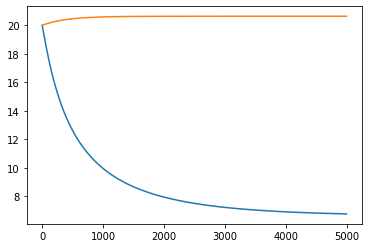

In [977]:
plt.plot(I)
plt.plot(y_Simon)

In [978]:


infected = np.zeros((ti,No_of_Iterations))
#recovered = np.zeros(300)

start_time = time.time()
for iteration in range(No_of_Iterations):
    x = np.zeros(len(X), dtype=np.float32)
    #init_I = np.random.randint(N - 1, size=y0)
    #print(init_I)
    #x[init_I] = 1
    x[:y0] = 1
    #print(iteration)
    for i in range(ti):
        if np.sum(x) == 0:
            x[ti:] = 0
            break
        for j in range(len(X)):   
            #r = np.random.rand(N)
            if x[j] == 0:
                s = 0
                r = np.random.random()
                for l in range(len(J[0])):
                    s = s + J[j][l] * np.dot(x,J)[l]
                #print(r, 1 - np.exp(-tau * s * 0.01))
                if r <= 1 - np.exp(-tau * s * 0.01):
                    x[j] = 1
                    #x = jax.ops.index_update(x, j, 1)
            if x[j] == 1:
                r = np.random.random()
                if r <= 1 - np.exp(-gamma * 0.01):
                    x[j] = 0
                    #x = jax.ops.index_update(x, j, 0)
        infected[i][iteration] = np.sum(x)
        #infected = jax.ops.index_update(infected, jax.ops.index[i, iteration], np.sum(x))
#plt.plot(infected)
#plt.plot(recovered)
end_time = time.time()
print("Run time = {}".format(end_time - start_time))

Run time = 1318.6933660507202


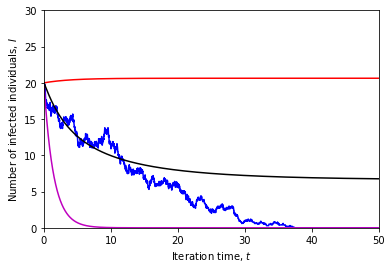

In [981]:
plt.plot(np.linspace(0, 50, 5000), np.mean(infected, axis=1), color = 'b')
plt.plot(np.linspace(0, 50, 5000), y_Simon, color = 'r')
plt.plot(np.linspace(0, 50, 5000), y_pairs[:,1], color = 'm')
plt.plot(np.linspace(0, 50, 5000), I, color = 'k')
plt.xlabel('Iteration time, $t$')
plt.ylabel('Number of infected individuals, $I$')
plt.ylim([0,30])
plt.xlim([0,50])
#plt.show()
plt.savefig('Figure3.png', dpi=600)

In [992]:
def dot_pr(f, g):
    result = np.zeros(len(g[0]))
    
    for b in range(len(g[0])):
        for a in range(len(f)):
            if x[a] == 1 and J[a][b] == 1:
                result[b] += 1;
    return result

dot_pr(x,J)

array([0.])

[9.]


In [ ]:
import random 
def partition (list_in, n):
    random.shuffle(list_in)
    return [list_in[i::n] for i in range(n)]

In [ ]:
def diff_eqs(INP,t):  
    Y = np.zeros((3))
    V = INP    
    Y[0] = - beta * V[0] * V[1]
    Y[1] = beta * V[0] * V[1] - gamma * V[1]
    return Y   # For odeint


In [ ]:
len(J[14])

In [ ]:
print(J)

In [ ]:
G = nx.barabasi_albert_graph(50,10)
A = list(nx.find_cliques(G))
J = np.zeros((len(G),len(A)))
for k in range(len(G)):
    for i in range(len(A)):
        for j in range(len(A[i])):
            #print(i, j, A[i][j])
            J[A[i][j]][i] = 1
print(J)

In [ ]:
len(J[0])

In [ ]:
git clone https://github.com/xianyi/OpenBLAS

In [297]:
pip install ray

^C
ERROR: Operation cancelled by user
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np

a = np.random.rand(10**6, 10**6)

def dot(a, b_row_size):
    b = np.random.rand(b_row_size, 10**4)
    return b

    for i in range(10):
        # dot operation
        x = np.dot(a, b.T)

# Using all CPU cores
print(dot(a, 1))



In [315]:
# Using only one CPU core
dot(a, 2)



array([[0.50563929, 0.36765016, 0.87535859, ..., 0.17571817, 0.46593194,
        0.90052046],
       [0.39008675, 0.13869541, 0.60232597, ..., 0.99455528, 0.62785208,
        0.21783606]])

In [ ]:
# Using only one CPU core
dot(a, 5)

# Using only one CPU core
dot(a, 15)

# Using all CPU cores
dot(a, 16)

# Using all CPU cores
dot(a, 50)